In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from common import *

set_random_seed(RANDOM_STATE)

In [2]:
import tensorflow as tf

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-18 21:12:37.679865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 21:12:37.682320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 21:12:37.682506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [3]:
data              = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

## 1) Feature engineering

In [4]:
%%time

IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 144
SHUFFLE     = True
TEST_SIZE   = 0.1
MARKER      = -9999


# Imputing
data_imp = impute_data(data)

# Outlier handling
# data_out = outlier_handler(data_imp, ['Etmp', 'Itmp', 'Wdir', 'Ndir'])

# Feature engineering
data_fe = feature_engineering(data_out, encode_TurbID=False, compute_Pmax_method='simple', compute_Pmax_clipping=False)

# Feature selection (select features)
# cols = select_features(data_fe)  # cols[-1]: Patv
cols = ['Wspd', 'Wspd_cube', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab', 'RPM', 'TSR', 'Pmax', 'Prtv', 'Patv']

# Split dataset
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data_fe, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)

# Mark anomaly
idxs_train_y_mark = [get_idxs_mark(d) for d in train_y]
idxs_val_y_mark   = [get_idxs_mark(d) for d in val_y]

# Feature selection (apply)
cols        = [col for col in cols if col in train_x[0]]  # except TurbID
train_x_sel = [d[cols] for d in train_x]
train_y_sel = [d[cols] for d in train_y]
val_x_sel   = [d[cols] for d in val_x]
val_y_sel   = [d[cols] for d in val_y]
test_x_sel  = [d[cols] for d in test_x]

# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_fe[cols].values)
train_x_norm = scale(train_x_sel, scaler)
train_y_norm = scale(train_y_sel, scaler)
val_x_norm   = scale(val_x_sel, scaler)
val_y_norm   = scale(val_y_sel, scaler)
test_x_norm  = scale(test_x_sel, scaler)

# Compute residual threshold
# idx_Pmax = cols.index('Pmax')
# data_scale    = scaler.transform(data_fe[cols])
# res_threshold = select_residual_threshold(data_scale[:, idx_Patv], data_scale[:, idx_Pmax])

# Final data
train_x_fin = train_x_norm
train_y_fin = train_y_norm
val_x_fin   = val_x_norm
val_y_fin   = val_y_norm
test_x_fin  = test_x_norm

# train_x_fin = np.array(train_x_sel, dtype=np.float32)
# train_y_fin = np.array(train_y_fin, dtype=np.float32)
# val_x_fin   = np.array(val_x_fin, dtype=np.float32)
# val_y_fin   = np.array(val_y_fin, dtype=np.float32)
# test_x_fin  = np.array(test_x_fin, dtype=np.float32)

# Set Patv of X to zero
idx_Patv = cols.index('Patv')
train_x_fin[:, :, idx_Patv] = 0
val_x_fin[:, :, idx_Patv]   = 0
test_x_fin[:, :, idx_Patv]  = 0

# Mark anomaly(apply)
train_y_mark_fin = copy(train_y_fin)
val_y_mark_fin   = copy(val_y_fin)
for idxs, d in zip(idxs_train_y_mark, train_y_mark_fin):
    d[idxs, idx_Patv] = MARKER
for idxs, d in zip(idxs_val_y_mark, val_y_mark_fin):
    d[idxs, idx_Patv] = MARKER

print("* Final data")
print("  - Train data(X, y)     :", np.shape(train_x_fin), np.shape(train_y_fin), np.shape(train_y_mark_fin))
print("  - Validation data(X, y):", np.shape(val_x_fin),   np.shape(val_y_fin),   np.shape(val_y_mark_fin))
print("  - Test data(X)         :", np.shape(test_x_fin))

100%|██████████| 134/134 [00:10<00:00, 13.35it/s]


* Data name: Imputing
  - Number of data: 3823222
  - Number of nan rows: 0


100%|██████████| 199/199 [00:16<00:00, 11.81it/s]


* Data name: Feature engineering
  - Number of data: 3823222
  - Number of nan rows: 0


100%|██████████| 134/134 [00:17<00:00,  7.77it/s]


* Data Split
  - Train data(X, y)     : (23427, 288, 43) (23427, 288, 43)
  - Validation data(X, y): (2678, 288, 43) (2678, 288, 43)
  - Test data(X)         : (134, 288, 43)
* Final data
  - Train data(X, y)     : (23427, 288, 12) (23427, 288, 12) (23427, 288, 12)
  - Validation data(X, y): (2678, 288, 12) (2678, 288, 12) (2678, 288, 12)
  - Test data(X)         : (134, 288, 12)
CPU times: user 2min 27s, sys: 11.7 s, total: 2min 39s
Wall time: 2min 16s


In [5]:
Pmax_constants = compute_Pmax_constants(data_fe, method='simple')
Patv_min_val   = data_fe['Patv'].min()
Patv_max_val   = data_fe['Patv'].max()

In [6]:
BATCH_SIZE = 128

train_ds = generate_dataset(train_x_fin, train_y_mark_fin, batch_size=BATCH_SIZE)
val_ds   = generate_dataset(val_x_fin, val_y_mark_fin, batch_size=BATCH_SIZE)
test_ds  = generate_dataset(test_x_fin, batch_size=1)

2022-07-18 21:14:59.079899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-18 21:14:59.080729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 21:14:59.080920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 21:14:59.081023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# 3. Modeling

In [7]:
from evaluation.metrics import CondLoss
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Input

class OutputLayer(layers.Layer):
    def __init__(self, min_val, max_val, **kwags):
        super().__init__(**kwags)
        self.min_val = min_val
        self.max_val = max_val
    def call(self, data):
        _, B, F = data.shape
        *other, Patv = tf.split(data, data.shape[2], axis=2)
        Patv = tf.clip_by_value(Patv, self.min_val, self.max_val)
        return tf.concat([*other, Patv], axis=2)
    def get_config(self):
        return super().get_config()
    
def build_model(input_shape, output_shape):
    S,  F  = input_shape
    S_, F_ = output_shape
    model = Sequential(name="GRU-Model") # Model
    model.add(Input(shape=(S, F), name='Input-Layer'))
    model.add(layers.Bidirectional(layers.GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer'))
    model.add(layers.RepeatVector(S_, name='Repeat-Vector-Layer'))
    model.add(layers.Bidirectional(layers.GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer'))
    model.add(layers.TimeDistributed(layers.Dense(units=F_), name='Output-Layer'))
    model.add(OutputLayer(Patv_min_val, Patv_max_val))
    
    model.compile(optimizer='nadam',
                  loss=CondLoss('rmse', marked_target_value=MARKER))
#                   metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])
    return model

# 4. Training

## 1) Feature selection(threshold=0.4)
- MAE: 310.936652232028

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras

ckpt_dir = join(PATH.ckpt, 'proposed23')
os.makedirs(ckpt_dir, exist_ok=True)

model = build_model(train_x_sel[0].shape, train_y_sel[0].shape)
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=30,
                    callbacks=[
                        PlotLossesKeras(),
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3),
                        ModelCheckpoint(join(ckpt_dir, '[{epoch:03d} epoch] val_loss: {val_loss:.3f}.h5'), save_best_only=False),
                    ])

## 2) Manual Feature selection
- cols = ['Wspd', 'Wspd_cube', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab', 'RPM', 'TSR', 'Pmax', 'Prtv', 'Patv']
- MAE: 250.29155574702474 (without outlier handling)
- MAE: 404.62565531934234 (with outlier handling)

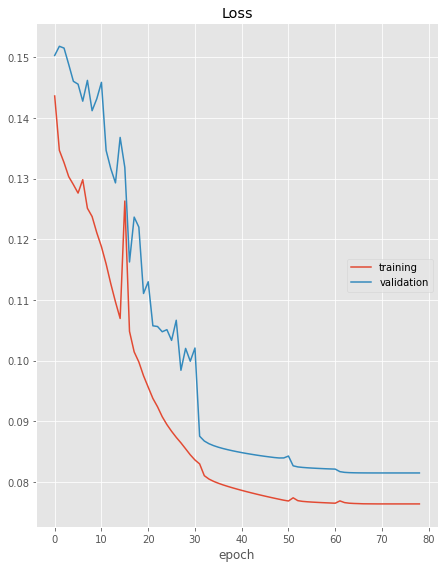

Loss
	training         	 (min:    0.076, max:    0.144, cur:    0.076)
	validation       	 (min:    0.081, max:    0.152, cur:    0.081)
184/184 [==============================] - 10s 54ms/step - loss: 0.0764 - val_loss: 0.0815 - lr: 1.0000e-11


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras

ckpt_dir = join(PATH.ckpt, 'proposed23-outlier')
os.makedirs(ckpt_dir, exist_ok=True)

model = build_model(train_x_sel[0].shape, train_y_sel[0].shape)
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=100,
                    callbacks=[
                        PlotLossesKeras(),
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3),
                        ModelCheckpoint(join(ckpt_dir, '[{epoch:03d} epoch].h5'), save_best_only=False),
                    ])

## 3) Manual Feature selection
- cols = ['Wspd', 'Wspd_cube', 'WspdX', 'Wdir', 'Etmp_abs', 'Pmax', 'Pab', 'RPM', 'TSR', 'Prtv', 'Patan', 'Papt', 'Patv']
- MAE: 382.0805877034615

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras

ckpt_dir = join(PATH.ckpt, 'proposed23')
os.makedirs(ckpt_dir, exist_ok=True)

model = build_model(train_x_sel[0].shape, train_y_sel[0].shape)
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=100,
                    callbacks=[
                        PlotLossesKeras(),
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3),
                        ModelCheckpoint(join(ckpt_dir, '[{epoch:03d} epoch] val_loss: {val_loss:.3f}.h5'), save_best_only=False),
                    ])

---

In [13]:
ckpt_path = join(PATH.ckpt, 'proposed23-outlier', '[020 epoch].h5')
model.load_weights(ckpt_path)

# 5. Check results

## 1) Training set

In [ ]:
def visualize(X, y_true, model, method):
#     X      = train_x_fin
#     y_true = train_y_fin
    if method == 1:
        y_pred = model.predict(X)

        y_true_fin = y_true[:, :, -1]
        y_pred_fin = y_pred[:, :, -1]
    elif method == 2:
        y_pred = model.predict(X)

        y_true_scale = scaler.inverse_transform(y_true.reshape(-1, y_true.shape[-1])).reshape(y_true.shape)
        y_pred_scale = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)

        y_true_fin = y_true_scale[:, :, -1]
        y_pred_fin = y_pred_scale[:, :, -1]
    elif method == 3:
        y_pred = model.predict(X)

        y_true_scale = scaler.inverse_transform(y_true.reshape(-1, y_true.shape[-1]))
        y_pred_scale = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))

        y_true_df = pd.DataFrame(y_true_scale, columns=cols)
        y_pred_df = pd.DataFrame(y_pred_scale, columns=cols)

        tmp = []
        for row in tqdm(X.reshape(-1, X.shape[-1])[:, :8].astype(int).astype(str)):
            tmp.append(int(''.join(row), 2))
        y_true_df['TurbID'] = y_pred_df['TurbID'] = tmp
        y_pred_df['Patv'] = compute_Pmax(y_pred_df, clipping=True,
                                         clipping_min_val=Patv_min_val,
                                         clipping_max_val=Patv_max_val,
                                         constants=Pmax_constants)

        y_true_fin = y_true_df['Patv'].values.reshape(y_true.shape[0], y_true.shape[1])
        y_pred_fin = y_pred_df['Patv'].values.reshape(y_pred.shape[0], y_pred.shape[1])
    visualize_result(y_true_fin, y_pred_fin, ylim=[-100, 2000])

In [ ]:
visualize(train_x_fin, train_y_fin, model, method=2)

## 2) Validation set

In [ ]:
visualize(val_x_fin, val_y_fin, model, method=2)

# 6. Generate submission

In [14]:
X      = test_x_fin
y_pred = model.predict(X)

y_pred_scale = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))

# y_pred_df = pd.DataFrame(y_pred_scale, columns=cols)

# tmp = []
# for row in tqdm(X.reshape(-1, X.shape[-1])[:, :8].astype(int).astype(str)):
#     tmp.append(int(''.join(row), 2))
# y_pred_df['TurbID'] = tmp
# y_pred_df['Patv'] = compute_Pmax(y_pred_df, clipping=True,
#                                  clipping_min_val=Patv_min_val,
#                                  clipping_max_val=Patv_max_val,
#                                  constants=Pmax_constants)
# y_pred_fin = y_pred_df['Patv'].values.reshape(y_pred.shape[0], y_pred.shape[1])

sample_submission['Patv'] = y_pred_scale[:, -1].reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed23-outlier.csv"), index=False)

5/5 [==============================] - 0s 18ms/step


---

In [ ]:
X      = test_x_fin
y_pred = model.predict(X)

y_pred_scale = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))
y_pred_df = pd.DataFrame(y_pred_scale, columns=cols)

tmp = []
for row in tqdm(X.reshape(-1, X.shape[-1])[:, :8].astype(int).astype(str)):
    tmp.append(int(''.join(row), 2))
y_pred_df['TurbID'] = tmp
y_pred_df['Patv'] = compute_Pmax(y_pred_df, clipping=True,
                                 clipping_min_val=Patv_min_val,
                                 clipping_max_val=Patv_max_val,
                                 constants=Pmax_constants)

In [ ]:
full_data = pd.read_csv(join(PATH.input, 'wtbdata_245days.csv'))
test_data = full_data[(201 <= full_data['Day']) & (full_data['Day'] <= 202)]

y_pred_fin = y_pred_df['Patv'].values.reshape(-1, 288)
y_true_fin = [test_data[test_data['TurbID'] == turbID]['Patv'] for turbID in test_data['TurbID'].unique()]

visualize_result(np.array(y_true_fin), np.array(y_pred_fin), ylim=[-100, 2000])

In [ ]:
full_data = pd.read_csv(join(PATH.input, 'wtbdata_245days.csv'))
test_data = full_data[(201 <= full_data['Day']) & (full_data['Day'] <= 202)]

y_pred_fin = y_pred_df['Patv'].values.reshape(-1, 288)
y_true_fin = [test_data[test_data['TurbID'] == turbID]['Patv'] for turbID in test_data['TurbID'].unique()]

visualize_result(np.array(y_true_fin), np.array(y_pred_fin), ylim=[-100, 2000])